# Dataviewer for spin exchange data

In [1]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import one_ring.base.fitting_tools as fitt
import one_ring.daq.nidaqmx_tools as ndaq
import one_ring.daq.stanford_research_systems as srs
import importlib
import one_ring.base.signal_tools as sit
from one_ring.base.pint_units import ureg
import one_ring.base.h5py_tools as h5t
import scipy.constants
from scipy import constants
%matplotlib widget
import time as tm
import pyvisa as visa
import one_ring.daq.visa_instruments as nvisa
plt.style.use("dark_background")
import pandas as pd
import one_ring.daq.thorlabs as thor
import one_ring.daq.tektronix as tek
import one_ring.base.pandas_tools as pdt
import one_ring.base.hdf5_tools as hdf

In [18]:
def larmor(B): #if the pump is on
    return (scipy.constants.physical_constants['electron gyromagn. ratio over 2 pi'][0] * ureg.MHz / ureg.T/ 4 * B).to(ureg.kHz)
def larmor2(B):
    return (14*ureg.kHz / ureg.uT * B).to(ureg.kHz)


# FG Check

In [157]:
file = "../data/Moku_FG_check.hdf5"

In [158]:
data = h5t.load_dataset(file, 'moku')

In [159]:
(1/(0.0005 * ureg.s)).to(ureg.kHz)

<Quantity(2.0, 'kilohertz')>

In [160]:
(10 / (50*ureg.us)).to(ureg.kHz)

<Quantity(200.0, 'kilohertz')>

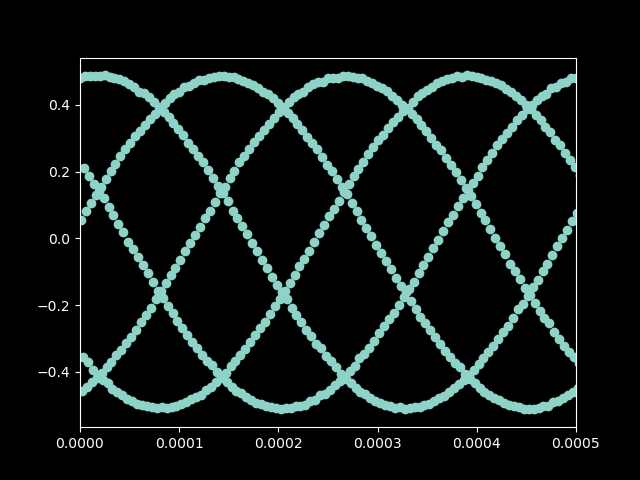

In [161]:
fig, ax = plt.subplots()
ax.scatter(data['Time (s)'], data['Input 1 (V)'])
ax.set_xlim(0,0.0005)
plt.show()

In [162]:
sa = sit.SignalFilterer(t=data['Time (s)']*ureg.s, y=data['Input 1 (V)']*ureg.V)

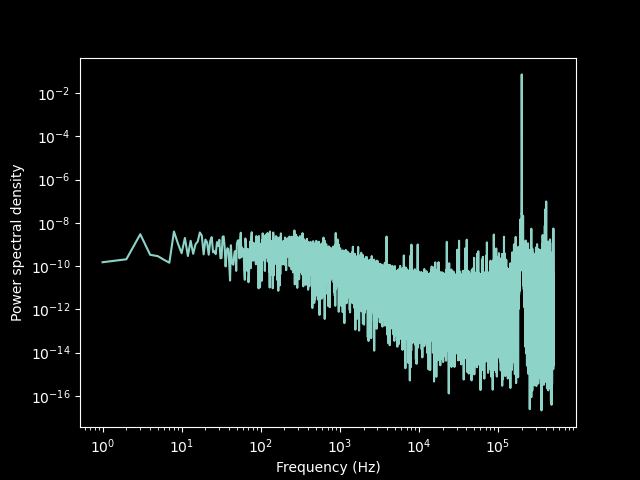

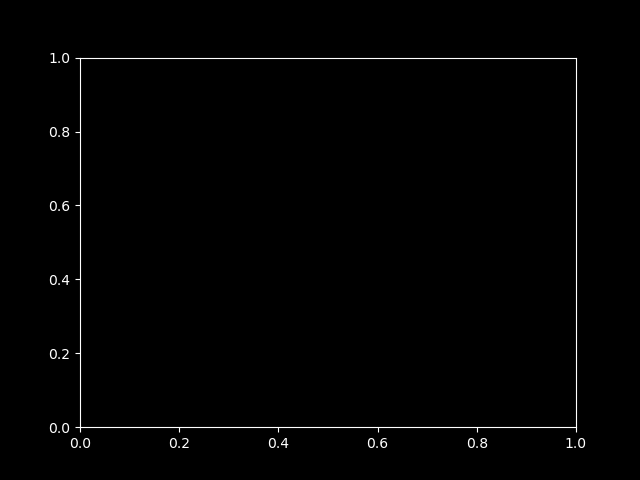

In [163]:
fig, ax = plt.subplots()
sa.plot_spectral_density()
plt.show()

In [104]:
data['Input 1 (V)'].max() - data['Input 1 (V)'].min()

<Quantity(1.011236, 'dimensionless')>

# First Test doneon 26/11/2025 (pump off and on)

In [2]:
file1="../data/T2_1.hdf5"
file2="../data/T2_2.hdf5"
file3="../data/T2_3.hdf5"

In [3]:
data1 = h5t.load_dataset(file1, 'moku') #AC input one, fs=1MHz 
data2 = h5t.load_dataset(file2, 'moku') #DC input one and two, fs=500kHz
data3 = h5t.load_dataset(file3, 'moku') #DC input one, fs=1MHz
md1 = h5t.get_node_metadata(file1, 'moku')
md2 = h5t.get_node_metadata(file2, 'moku')
md3 = h5t.get_node_metadata(file3, 'moku')

In [4]:
md1

{'comment': array(['% Moku:Go Data Logger\r\n% Input 1 (on), AC , 1 MOhm , 10 Vpp\r\n% Input 2 (off), DC , 1 MOhm , 10 Vpp\r\n% Acquisition rate: 1.0080645161e+06 Hz, Normal mode, trigger: Input 2, level: 0.000 V\r\n% Output 1 (off) - Sine, 10.000 000 000 000 MHz, 1.000 0 Vpp, offset 0.000 0 V, phase 0.000 000 deg\r\n% Output 2 (off) - Square, 50.000 000 000 kHz, 500.0 mVpp, offset 0.000 0 V, phase 0.000 000 deg, duty cycle 50.00 %\r\n% \r\n% Acquired 2025-11-26 T 18:24:37 +0800\r\n% Time (s), Input 1 (V)\r\n'],
       dtype=object),
 'timestamp': array(['2025-11-26 T 18:24:37 +0800'], dtype=object),
 'version': array(['4.0.2'], dtype=object)}

C:\Users\labuser_L213\miniforge3\envs\one_ring\lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


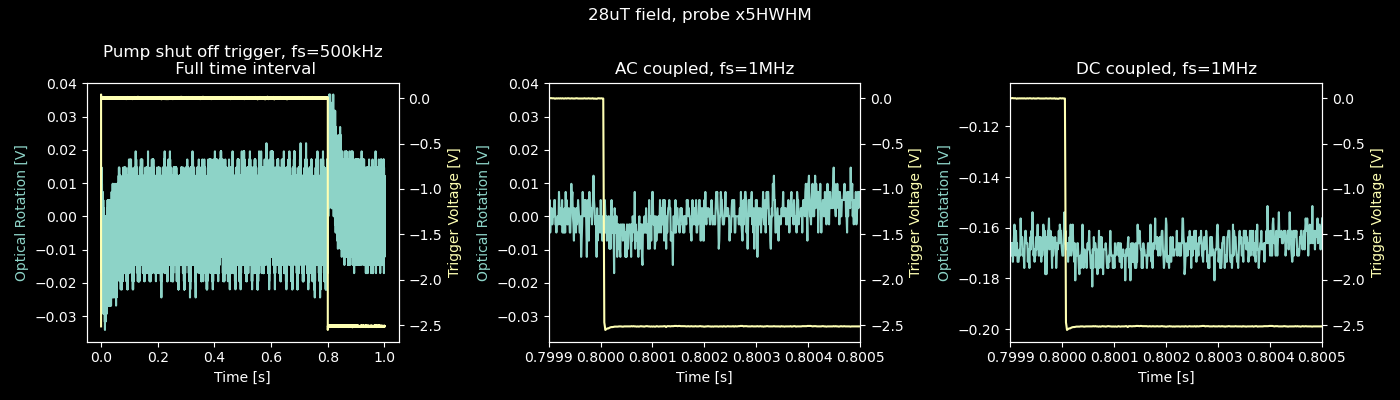

In [5]:
fig, axes = plt.subplots(figsize=(14,4),ncols=3)
ax1, ax2, ax3 = axes
ax1_2 = ax1.twinx()
ax2_2 = ax2.twinx()
ax3_2 = ax3.twinx()

delT1 = 0.0001
delT2 = 0.0005

ax1.plot(data1['Time (s)'], data1['Input 1 (V)'])
ax1_2.plot(data2['Time (s)'], data2['Input 2 (V)'],color='C1')
ax2.plot(data1['Time (s)'], data1['Input 1 (V)'])
ax2_2.plot(data2['Time (s)'], data2['Input 2 (V)'], color='C1')
ax3.plot(data3['Time (s)'], data3['Input 1 (V)'])
ax3_2.plot(data2['Time (s)'], data2['Input 2 (V)'], color='C1')

ax2.set_xlim(0.8-delT1,0.8+delT2)
ax3.set_xlim(0.8-delT1,0.8+delT2)

for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('Optical Rotation [V]')
    ax.yaxis.label.set_color('C0')
    ax.set_xlabel('Time [s]')
for ax in [ax1_2, ax2_2, ax3_2]:
    ax.set_ylabel('Trigger Voltage [V]')
    ax.yaxis.label.set_color('C1')

ax2.set_title('AC coupled, fs=1MHz')
ax1.set_title('Pump shut off trigger, fs=500kHz\n Full time interval')
ax3.set_title('DC coupled, fs=1MHz')
plt.suptitle('28uT field, probe x5HWHM')
plt.tight_layout()
plt.show()

# Test run #2 (turnign pump off and on)
testing the different modes at 0.9mW of probe power and 5mW of pump power

In [11]:
file1="../data/T2_wulgang_both_inputs.hdf5" #DC input 1 and 2, fs = 500 kHz, precision mode
file2="../data/T2_wulgang_both_inputs_2.hdf5" #DC input 1 and 2, fs = 500 kHz, normal mode
file3="../data/T2_wulgang_1_DC_normal.hdf5" #DC input 1, fs = 1MHz, normal mode
file4="../data/T2_wulgang_1_DC_precision.hdf5" #DC input 1, fs = 1MHz, precision mode
file5="../data/T2_wulgang_1_DC_peaks.hdf5" #DC input 1, fs = 1MHz, peaks mode
file6="../data/T2_wulgang_1_AC_normal.hdf5" #ACinput 1, fs = 1MHz, normal mode
file7="../data/T2_wulgang_1_AC_precision.hdf5" #AC input 1, fs = 1MHz, precision mode
file8="../data/T2_wulgang_1_AC_peaks.hdf5" #AC input 1, fs = 1MHz, peaks mode
file9="../data/T2_wulgang_both_inputs_peaks.hdf5" #DC input 1 and 2, fs = 500 kHz, peaks mode

In [24]:
data1 = h5t.load_dataset(file1, 'moku')  
data2 = h5t.load_dataset(file2, 'moku')
data3 = h5t.load_dataset(file3, 'moku') 
data4 = h5t.load_dataset(file4, 'moku') 
data5 = h5t.load_dataset(file5, 'moku')
data6 = h5t.load_dataset(file6, 'moku') 
data7 = h5t.load_dataset(file7, 'moku') 
data8 = h5t.load_dataset(file8, 'moku') 
data9 = h5t.load_dataset(file9, 'moku')
md1 = h5t.get_node_metadata(file1, 'moku')
md2 = h5t.get_node_metadata(file2, 'moku')
md3 = h5t.get_node_metadata(file3, 'moku')
md6 = h5t.get_node_metadata(file6, 'moku')

In [27]:
md1

{'comment': array(['% Moku:Go Data Logger\r\n% Input 1 (on), DC , 1 MOhm , 10 Vpp\r\n% Input 2 (on), DC , 1 MOhm , 10 Vpp\r\n% Acquisition rate: 4.9603174603e+05 Hz, Precision mode, trigger: Input 2, level: 0.000 V\r\n% Output 1 (off) - Sine, 10.000 000 000 000 MHz, 1.000 0 Vpp, offset 0.000 0 V, phase 0.000 000 deg\r\n% Output 2 (off) - Square, 50.000 000 000 kHz, 500.0 mVpp, offset 0.000 0 V, phase 0.000 000 deg, duty cycle 50.00 %\r\n% \r\n% Acquired 2025-11-27 T 15:06:24 +0800\r\n% precision varient\r\n% Time (s), Input 1 (V), Input 2 (V)\r\n'],
       dtype=object),
 'timestamp': array(['2025-11-27 T 15:06:24 +0800'], dtype=object),
 'version': array(['4.0.2'], dtype=object)}

### Normal mode

In [28]:
field = 50*ureg.uT
larmor(field)

<Quantity(350.311915, 'kilohertz')>

In [30]:
(field_period).to(ureg.s)

<Quantity(5.097498e-06, 'second')>

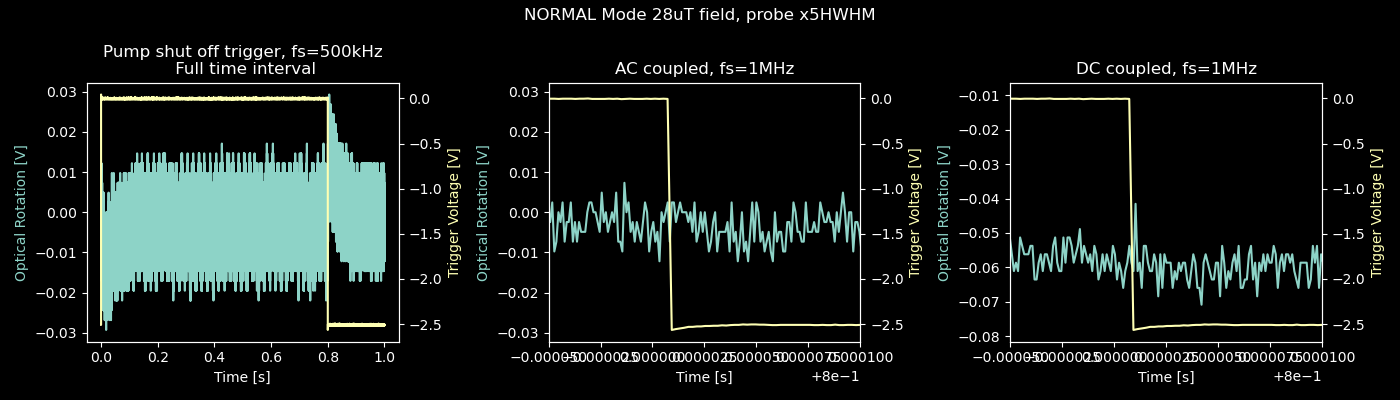

In [21]:
fig, axes = plt.subplots(figsize=(14,4),ncols=3)
ax1, ax2, ax3 = axes
ax1_2 = ax1.twinx()
ax2_2 = ax2.twinx()
ax3_2 = ax3.twinx()

delT1 = 0.00005
delT2 = 0.0001
t_start = 0.8*ureg.s
hold_time = 0.1*ureg.s
t2_expected = 100*ureg.us
field = 28*ureg.uT
field_period = 1/larmor(field)

trigger_data = data2
DC_data = data3
AC_data = data6

ax1.plot(AC_data['Time (s)'], AC_data['Input 1 (V)'])
ax1_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 (V)'],color='C1')
ax2.plot(AC_data['Time (s)'], AC_data['Input 1 (V)'])
ax2_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 (V)'], color='C1')
ax3.plot(DC_data['Time (s)'], DC_data['Input 1 (V)'])
ax3_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 (V)'], color='C1')

ax2.set_xlim(0.8-delT1,0.8+delT2)
ax3.set_xlim(0.8-delT1,0.8+delT2)


for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('Optical Rotation [V]')
    ax.yaxis.label.set_color('C0')
    ax.set_xlabel('Time [s]')
for ax in [ax1_2, ax2_2, ax3_2]:
    ax.set_ylabel('Trigger Voltage [V]')
    ax.yaxis.label.set_color('C1')

ax2.set_title('AC coupled, fs=1MHz')
ax1.set_title('Pump shut off trigger, fs=500kHz\n Full time interval')
ax3.set_title('DC coupled, fs=1MHz')
plt.suptitle('NORMAL Mode 28uT field, probe x5HWHM')
plt.tight_layout()
plt.show()

### Precision Mode

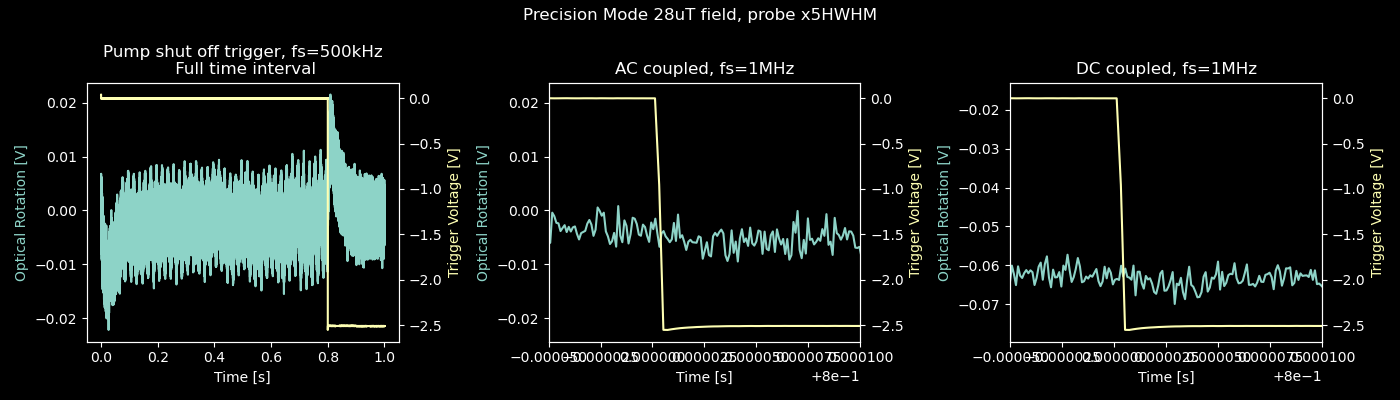

In [8]:
fig, axes = plt.subplots(figsize=(14,4),ncols=3)
ax1, ax2, ax3 = axes
ax1_2 = ax1.twinx()
ax2_2 = ax2.twinx()
ax3_2 = ax3.twinx()

delT1 = 0.00005
delT2 = 0.0001

trigger_data = data1
DC_data = data4
AC_data = data7

ax1.plot(AC_data['Time (s)'], AC_data['Input 1 (V)'])
ax1_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 (V)'],color='C1')
ax2.plot(AC_data['Time (s)'], AC_data['Input 1 (V)'])
ax2_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 (V)'], color='C1')
ax3.plot(DC_data['Time (s)'], DC_data['Input 1 (V)'])
ax3_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 (V)'], color='C1')

ax2.set_xlim(0.8-delT1,0.8+delT2)
ax3.set_xlim(0.8-delT1,0.8+delT2)

for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('Optical Rotation [V]')
    ax.yaxis.label.set_color('C0')
    ax.set_xlabel('Time [s]')
for ax in [ax1_2, ax2_2, ax3_2]:
    ax.set_ylabel('Trigger Voltage [V]')
    ax.yaxis.label.set_color('C1')

ax2.set_title('AC coupled, fs=1MHz')
ax1.set_title('Pump shut off trigger, fs=500kHz\n Full time interval')
ax3.set_title('DC coupled, fs=1MHz')
plt.suptitle('Precision Mode 28uT field, probe x5HWHM')
plt.tight_layout()
plt.show()

### Peaks Mode

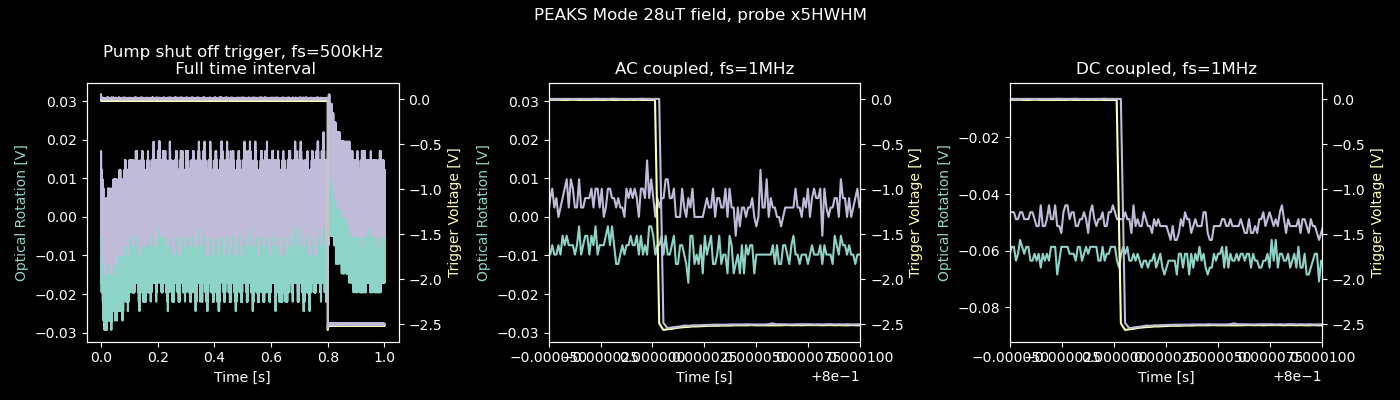

In [10]:
fig, axes = plt.subplots(figsize=(14,4),ncols=3)
ax1, ax2, ax3 = axes
ax1_2 = ax1.twinx()
ax2_2 = ax2.twinx()
ax3_2 = ax3.twinx()

delT1 = 0.00005
delT2 = 0.0001

trigger_data = data9
DC_data = data5
AC_data = data8

ax1.plot(AC_data['Time (s)'], AC_data['Input 1 min (V)'])
ax1_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 min (V)'],color='C1')
ax2.plot(AC_data['Time (s)'], AC_data['Input 1 min (V)'])
ax2_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 min (V)'], color='C1')
ax3.plot(DC_data['Time (s)'], DC_data['Input 1 min (V)'])
ax3_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 min (V)'], color='C1')

ax1.plot(AC_data['Time (s)'], AC_data['Input 1 max (V)'],color='C2')
ax1_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 max (V)'],color='C2')
ax2.plot(AC_data['Time (s)'], AC_data['Input 1 max (V)'],color='C2')
ax2_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 max (V)'], color='C2')
ax3.plot(DC_data['Time (s)'], DC_data['Input 1 max (V)'],color='C2')
ax3_2.plot(trigger_data['Time (s)'], trigger_data['Input 2 max (V)'], color='C2')

ax2.set_xlim(0.8-delT1,0.8+delT2)
ax3.set_xlim(0.8-delT1,0.8+delT2)

for ax in [ax1, ax2, ax3]:
    ax.set_ylabel('Optical Rotation [V]')
    ax.yaxis.label.set_color('C0')
    ax.set_xlabel('Time [s]')
for ax in [ax1_2, ax2_2, ax3_2]:
    ax.set_ylabel('Trigger Voltage [V]')
    ax.yaxis.label.set_color('C1')

ax2.set_title('AC coupled, fs=1MHz')
ax1.set_title('Pump shut off trigger, fs=500kHz\n Full time interval')
ax3.set_title('DC coupled, fs=1MHz')
plt.suptitle('PEAKS Mode 28uT field, probe x5HWHM')
plt.tight_layout()
plt.show()